In [58]:
# libs
import pandas as pd
import numpy as np
from datetime import datetime

# stats R type shit 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from statsmodels.api import OLS
import statsmodels.api as sm

# bar plots
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
# today's date string for file namine automation
today_date_str = datetime.now().strftime("_%Y-%m-%d.csv")
print(today_date_str)

_2024-02-23.csv


In [50]:
# cocncat base file name with today's date string
filename = f"trading_view_raw_data/tv_screen_gap-up{today_date_str}"

# read in trading view raw data
trading_view_raw_df = pd.read_csv(filename)

print(f'{len(trading_view_raw_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
trading_view_raw_df.head(5)

1168 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,...,Relative Volume 1 week,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Beta 1 year,Beta 3 years,Beta 5 years
0,MSFT,Microsoft Corporation,NASDAQ,3049005077458.27,USD,410.34,USD,4.0400,USD,0.981416,...,0.73104368,1.684720,1.407963,1.572144,411.723333,37.11233912,Technology Services,0.98372686,1.0329885,0.8991026
1,AAPL,Apple Inc.,NASDAQ,2818452019809.7324,USD,182.52,USD,0.6300,USD,0.341704,...,0.72922452,1.542007,1.373282,1.651346,183.263333,28.39894196,Electronic Technology,1.0909481,1.2225922,1.3124571
2,NVDA,NVIDIA Corporation,NASDAQ,1946779912103.8457,USD,788.17,USD,22.4300,USD,2.855942,...,1.46836546,6.218899,5.576206,3.700871,795.936667,66.03024337,Electronic Technology,1.5339884,2.2734668,1.6840769
3,META,"Meta Platforms, Inc.",NASDAQ,1233988645845.5662,USD,484.03,USD,2.0000,USD,0.411413,...,0.76258177,2.490255,2.259796,2.576637,486.912700,32.49330371,Technology Services,1.3388069,1.0570395,1.1544267
4,BRK.B,Berkshire Hathaway Inc. New,NYSE,905291407816.9218,USD,417.22,USD,2.4906,USD,0.599913,...,0.86245592,1.296456,1.044239,1.237290,418.100000,11.86622412,Finance,0.66524845,0.86781585,0.8809025


In [35]:
# first 10 rows df
trading_view_raw_df_testing = trading_view_raw_df.head(10)
# save to csv
trading_view_raw_df_testing.to_csv('trading_view_raw_data/tv_screen_gap-up_testing.csv', index=False)
# make sure data is there at least
print(len(trading_view_raw_df_testing.index))

# print test df
trading_view_raw_df_testing

10


In [51]:
# baseline raw cols from trading view initial filter
features_raw_all = trading_view_raw_df.columns
# convert to list
features_raw_all = features_raw_all.tolist()
# look at the trading view columns
print(features_raw_all)

['Symbol', 'Description', 'Exchange', 'Market capitalization', 'Market capitalization - Currency', 'Price', 'Price - Currency', 'Pre-market Change', 'Pre-market Change - Currency', 'Pre-market Change %', 'Pre-market Gap %', 'Float shares outstanding', 'Volume 1 day', 'Relative Volume 1 day', 'Average Volume 10 days', 'Pre-market Volume', 'Relative Volume at Time', 'Relative Volume at Time.1', 'Volume 1 week', 'Relative Volume 1 week', 'Volatility 1 day', 'Volatility 1 week', 'Volatility 1 month', 'Volume Weighted Average Price 1 day', 'Price to earnings ratio', 'Sector', 'Beta 1 year', 'Beta 3 years', 'Beta 5 years']


In [ ]:
"""
define function -> add new column and marketCapType based on 'Market capitalization' column

criteria (6 groupings):
200B and above = 'Titans' - 1
10B to 200B = 'Large caps' - 2
2B to 10B = 'Midlers' - 3
300M to 2B = 'Small caps' - 4
300m and below = 'Micro caps' - 5
50m and below = 'Shrimp' - 6

"""

In [52]:
def categorize_market_cap(df):
    # Convert 'Market capitalization' to numeric, coercing errors to NaN
    df['Market capitalization'] = pd.to_numeric(df['Market capitalization'], errors='coerce')
    
    # Define a new column 'MarketCapType' with default values
    df['MarketCapType'] = 'Undefined'
    
    # Define the conditions for each market cap category using regular number notation
    conditions = [
        (df['Market capitalization'] >= 200000000000),  # 200 billion and above
        (df['Market capitalization'] >= 10000000000) & (df['Market capitalization'] < 200000000000),  # 10 billion to 200 billion
        (df['Market capitalization'] >= 2000000000) & (df['Market capitalization'] < 10000000000),  # 2 billion to 10 billion
        (df['Market capitalization'] >= 300000000) & (df['Market capitalization'] < 2000000000),  # 300 million to 2 billion
        (df['Market capitalization'] > 50000000) & (df['Market capitalization'] < 300000000),  # 300 million and below (excluding 50 million and below)
        (df['Market capitalization'] <= 50000000)  # 50 million and below
    ]
    
    # Define the category names corresponding to each condition
    categories = ['Titans', 'Large caps', 'Midlers', 'Small caps', 'Micro caps', 'Shrimp']
    
    # Use np.select to assign categories based on conditions
    df['marketCapType'] = np.select(conditions, categories, default='Undefined')
    
    return df


In [53]:
# EXECUTE
trading_view_raw_df = categorize_market_cap(trading_view_raw_df)
trading_view_raw_df.head(5)

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,...,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Beta 1 year,Beta 3 years,Beta 5 years,MarketCapType,marketCapType
0,MSFT,Microsoft Corporation,NASDAQ,3.049005e+12,USD,410.34,USD,4.0400,USD,0.981416,...,1.407963,1.572144,411.723333,37.11233912,Technology Services,0.98372686,1.0329885,0.8991026,Undefined,Titans
1,AAPL,Apple Inc.,NASDAQ,2.818452e+12,USD,182.52,USD,0.6300,USD,0.341704,...,1.373282,1.651346,183.263333,28.39894196,Electronic Technology,1.0909481,1.2225922,1.3124571,Undefined,Titans
2,NVDA,NVIDIA Corporation,NASDAQ,1.946780e+12,USD,788.17,USD,22.4300,USD,2.855942,...,5.576206,3.700871,795.936667,66.03024337,Electronic Technology,1.5339884,2.2734668,1.6840769,Undefined,Titans
3,META,"Meta Platforms, Inc.",NASDAQ,1.233989e+12,USD,484.03,USD,2.0000,USD,0.411413,...,2.259796,2.576637,486.912700,32.49330371,Technology Services,1.3388069,1.0570395,1.1544267,Undefined,Titans
4,BRK.B,Berkshire Hathaway Inc. New,NYSE,9.052914e+11,USD,417.22,USD,2.4906,USD,0.599913,...,1.044239,1.237290,418.100000,11.86622412,Finance,0.66524845,0.86781585,0.8809025,Undefined,Titans


In [ ]:
# check for NaNs
print(trading_view_raw_df.isna().sum())

In [55]:
# drop NaNs
trading_view_raw_df = trading_view_raw_df.dropna()
# get simple count of NaNs total. should be 0
print(f'NaNs = {trading_view_raw_df.isna().sum().sum()}')

# if there are no NaNs, print "No NaNs in DataFrame! Success!", else print the NaN count and "There are x NaNs in DataFrame, check your code dumb dumb!"
if trading_view_raw_df.isna().sum().sum() == 0:
    nan_count = trading_view_raw_df.isna().sum().sum()
    print(f"There are zero {nan_count} NaNs in DataFrame! Nice work!")
else:
    print(f"There are {trading_view_raw_df.isna().sum().sum()} NaNs in DataFrame, check your code dumb dumb!")


NaNs = 0
There are zero 0 NaNs in DataFrame! Nice work!


In [56]:
# creat a dataframe to break down the marketCapType counts
mc_groups = trading_view_raw_df['marketCapType'].value_counts().reset_index()

mc_groups

,marketCapType,count
0,Large caps,266
1,Small caps,245
2,Shrimp,219
3,Midlers,215
4,Micro caps,183
5,Titans,27


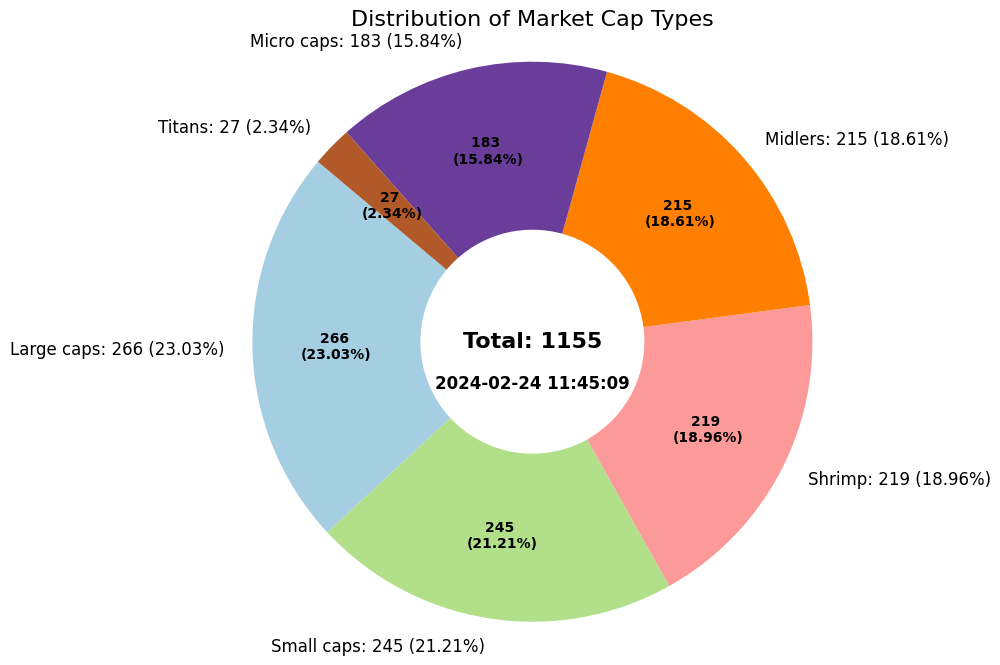

In [72]:
labels = mc_groups['marketCapType']
sizes = mc_groups['count']
# Calculate percentage for each market cap type
percentages = (sizes / sizes.sum()) * 100

# Custom labels with both count and percentage, formatted for readability
labels = [f'{label}: {size} ({percent:.2f}%)' for label, size, percent in zip(labels, sizes, percentages)]

# Choose a color palette
colors = plt.cm.Paired(np.linspace(0, 1, len(labels)))

# Create pie chart
plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(sizes, labels=labels, colors=colors, startangle=140, autopct='',
                                   pctdistance=0.85, wedgeprops=dict(width=0.6), textprops={'fontsize': 12})

# Customize the autotexts (for autopct)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_weight('bold')

# Add custom count and percentage text inside the wedges
for i, p in enumerate(wedges):
    angle = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(angle))
    x = np.cos(np.deg2rad(angle))
    percentage = f'{sizes[i]} \n({percentages[i]:.2f}%)'
    plt.text(x*0.7, y*0.7, percentage, ha='center', va='center', fontsize=10, color='black', weight='bold')

plt.title('Distribution of Market Cap Types', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

# put total and date time in the center of donut
plt.text(0, 0, f'Total: {sizes.sum()}', ha='center', va='center', fontsize=16, color='black', weight='bold')
plt.text(0, -0.15, datetime.now().strftime('%Y-%m-%d %H:%M:%S'), ha='center', va='center', fontsize=12, color='black', weight='bold')

plt.show()

END - END - END - IN PROGRESS - END - END - END END - END - END - IN PROGRESS - END - END - END END - END - END - IN PROGRESS - END - END - END

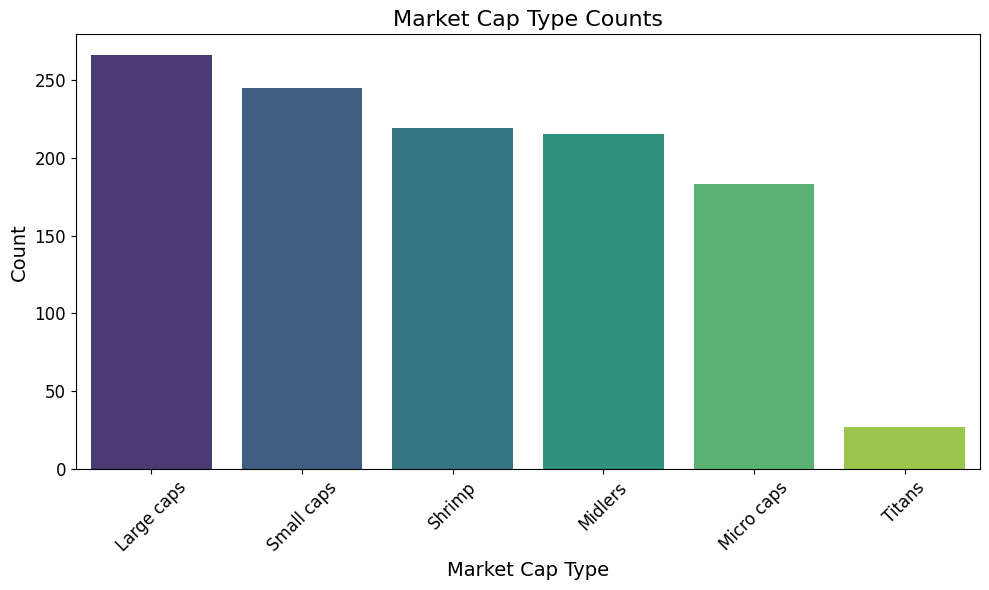

In [62]:
# plt.figure(figsize=(10, 6))
# # Assign 'marketCapType' to both x and hue, and disable the legend.
# sns.barplot(data=mc_groups, x='marketCapType', y='count', hue='marketCapType', palette='viridis', legend=False)
# plt.title('Market Cap Type Counts', fontsize=16)
# plt.xlabel('Market Cap Type', fontsize=14)
# plt.ylabel('Count', fontsize=14)
# plt.xticks(rotation=45, fontsize=12)
# plt.yticks(fontsize=12)
# plt.tight_layout()

# # Since we're now using 'hue', you'll need to remove the legend explicitly if it still appears.
# plt.legend([],[], frameon=False)

# plt.show()

In [ ]:
# feature selection
# features = ['Market capitalization', 'Volume 1 day', 'Volatility 1 week', 'Beta 1 year', 'Sector']
# features = features_raw_all
# target = 'Post-market Change %'

# # Preprocessing data: Drop rows with missing values in the selected columns
# tv_clean_df = trading_view_raw_df[features + [target]].dropna()

# # Check the unique values and their frequency for the target variable
# print(tv_clean_df['Post-market Change %'].value_counts())


# # Encoding categorical variables and scaling numerical variables
# categorical_features = ['Sector']
# numeric_features = list(set(features) - set(categorical_features))

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numeric_features),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
#     ])

# # Prepare the data for modeling
# X = tv_clean_df[features]
# y = tv_clean_df[target]

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define and fit the model
# model = Pipeline(steps=[('preprocessor', preprocessor),
#                         ('regressor', LinearRegression())])

# model.fit(X_train, y_train)

# # Predict and evaluate the model
# y_pred = model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f'MSE: {mse}')
# print(f'R^2: {r2}')

# # For detailed statistics, we need to fit the model using statsmodels
# # We'll prepare the data again because statsmodels requires it to be done differently
# X_train_transformed = model.named_steps['preprocessor'].transform(X_train)
# X_train_transformed = sm.add_constant(X_train_transformed)  # Adding a constant for the intercept

# # Fit the model using OLS
# ols_model = sm.OLS(y_train, X_train_transformed).fit()

# # Print the summary of the model to see detailed statistics
# print(ols_model.summary())
